# Tutorial 4. Network Simulation

In this tutorial I show how we can combine several simulation iterations in order to find out what would have been the most likely paths.

### imports

In [1]:
import netsim.netgen as ng
import netsim.utils as utils
import netsim.netsim as ns
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as ro

### Reading files

#### *Read DEM*

In [2]:
fn = r'..\data\sample\sampleDEM.tif'

In [3]:
dem, profile = utils.read_raster(fn)

In [4]:
#find the cellsize of the dem
cellsize = profile['affine'].a

#### *Read shapefile into a geopandas dataframe*

In [5]:
# change 5 or 15
fn = r'..\data\sample\sample5.shp'

##### read and make a copy of original dataframe

In [6]:
df_temp = gpd.read_file(fn)

# make a copy
df = df_temp.copy(deep=True)
df

,id,seq,group,mix,easting,northing,geometry
0,0,1,1,0,530782,4389390,POINT (530782 4389390)
1,1,1,1,0,531119,4388860,POINT (531119 4388860)
2,2,1,1,0,530403,4388580,POINT (530403 4388580)
3,3,1,1,0,530503,4388620,POINT (530503 4388620)
4,4,1,1,0,530729,4388930,POINT (530729 4388930)
5,5,1,1,0,530606,4389150,POINT (530606 4389150)


### Preliminaries

#### *Convert point coordinates into rows and column and add to dataframe*

In [7]:
df['r'], df['c'] = utils.pt2rc(df['geometry'], profile)
df

,id,seq,group,mix,easting,northing,geometry,r,c
0,0,1,1,0,530782,4389390,POINT (530782 4389390),18,104
1,1,1,1,0,531119,4388860,POINT (531119 4388860),124,171
2,2,1,1,0,530403,4388580,POINT (530403 4388580),180,28
3,3,1,1,0,530503,4388620,POINT (530503 4388620),172,48
4,4,1,1,0,530729,4388930,POINT (530729 4388930),110,93
5,5,1,1,0,530606,4389150,POINT (530606 4389150),66,68


In [8]:
# check values
df = ng.setup(df)


 No corrections or errors !! 


#### *Plot locations*

In [9]:
hillshade = utils.calculate_hillshade(dem)

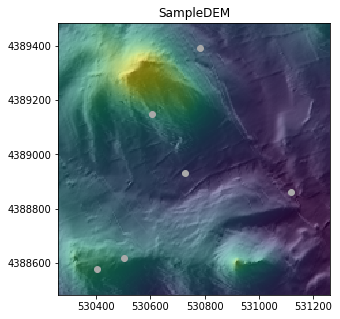

In [10]:
utils.plot_map({'ras':dem, 'profile':profile, 'bground': hillshade}, loc=df, title='SampleDEM')

### create network generator

In [11]:
# create network generator
netgentor, net_info, total_iterations = ng.create_network_generator(df)


 iteration broken per group....

   group  num_loc  num_iter iter_type
0      1        6       100    sample

 total number of iterations.... 100


### Setup Simulation

##### *find coefficients for gradient to cost function*

In [12]:
# vertical factor table
vftfn = r'..\data\iwdt\grad2cost.csv'

# read file slope (tan) to cost
vft = np.genfromtxt(vftfn, delimiter=',')

In [13]:
# fit values to 4th degree polynomial and return coefficients
coef = np.polyfit(np.tan(np.radians(vft[: , 0])), vft[:,1], deg=4)
coef

array([ 14.58472386, -20.89105302,  41.30992529,  16.89952776,
         2.57058679])

##### Set up cost dictionary

In [14]:
cost_dict={
    'dem': dem,
    'netcost': np.zeros_like(dem),
    'cellsize': cellsize,
    'weight': 0.5,
    'coef': coef
}

##### Set up netsim dictionary

##### *calculate decay factor $\alpha$ for given $d_0$ and $NC_0$*

We shall specify that at a distance of $d_0$=10m the network cost (i.e. the effect of the existing network) will decrease to $\frac{1}{2} $.  

In [15]:
from math import log

d0 = 10 # distance @ which 
NC0 = 0.5  # cost reduces to 50%
alpha = d0 / log(1- NC0)

In [16]:
netsim_dict= {
    'i': 1.0,      # path impact
    'Gmax': 5.0,   # path saturation
    'T': 10,       # residuality 
    'alpha': alpha # decay factor 
    }

#### Run *nsim* simulations

In [17]:
progress = lambda i, n=10: print ('X', end = "") if i % n == 0 else print('.', end = "")

In [18]:
# number of iterations 
nsim = 2

##### initialize variables

In [19]:
all_path_lst = []
all_paths = np.zeros_like(dem, dtype=np.float64)
prev_id = 0
save_flag = True
save_fn =  './all_paths'

##### run simulations

In [20]:
for isim in range(nsim):
    
    # progress
    progress(isim)
    
    # generate network iteration
    net_iteration = list(next(netgentor))
    
    # create path network layout for current iteration
    df_net = ng.network_layout(df, net_iteration, isim, opt='all')
    
    # simulate network
    _, paths, path_lst = ns.simulation(df, df_net, cost_dict, netsim_dict)
    
    # add current iteration path list to that of previous iterations 
    for pth in path_lst:
#         pth[0]['id'] += prev_id
#         all_path_lst.append(pth[0])
        pth['id'] += prev_id
        all_path_lst.append(pth)
        
    # update last id
    prev_id = len(all_path_lst)
    
    # generate dataframe output
    df_paths = pd.DataFrame(all_path_lst, columns=['id', 'origin','destination', 'track'])
    
    # add current path network to path networks from previous iterations
    all_paths += paths
    
    if save_flag:
        df_paths.to_pickle(save_fn)
        with ro.open( save_fn+'.tif', 'w', **profile) as ras:
            ras.write(all_paths, 1)

X

C:\Python\Miniconda3\envs\network\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


.

In [21]:
df_paths

,id,origin,destination,track
0,1,"[172, 48]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."
1,2,"[172, 48]","[180, 28]","[[180, 180, 180, 179, 179, 179, 179, 179, 178,..."
2,3,"[172, 48]","[110, 93]","[[110, 111, 112, 113, 114, 115, 116, 117, 118,..."
3,4,"[172, 48]","[124, 171]","[[124, 124, 123, 123, 122, 122, 121, 121, 120,..."
4,5,"[172, 48]","[66, 68]","[[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, ..."
5,6,"[18, 104]","[180, 28]","[[180, 180, 180, 179, 179, 179, 179, 179, 178,..."
6,7,"[18, 104]","[110, 93]","[[110, 109, 108, 107, 106, 105, 104, 103, 102,..."
7,8,"[18, 104]","[124, 171]","[[124, 123, 122, 121, 120, 119, 118, 117, 116,..."
8,9,"[18, 104]","[66, 68]","[[66, 66, 67, 67, 67, 67, 68, 68, 69, 69, 70, ..."
9,10,"[180, 28]","[110, 93]","[[110, 111, 112, 113, 114, 115, 116, 117, 118,..."


In [24]:
df_paths.to_pickle('./test.pkl')

In [25]:
df_tmp = pd.read_pickle('./test.pkl')

In [26]:
df_tmp

,id,origin,destination,track
0,1,"[124, 171]","[172, 48]","[[172, 172, 172, 172, 172, 171, 171, 171, 171,..."
1,2,"[124, 171]","[66, 68]","[[66, 66, 67, 67, 68, 69, 70, 71, 72, 73, 74, ..."
2,3,"[124, 171]","[180, 28]","[[180, 180, 180, 180, 180, 180, 180, 180, 180,..."
3,4,"[124, 171]","[110, 93]","[[110, 111, 112, 113, 114, 115, 116, 117, 118,..."
4,5,"[124, 171]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."
5,6,"[172, 48]","[66, 68]","[[66, 67, 68, 68, 69, 70, 71, 72, 73, 74, 75, ..."
6,7,"[172, 48]","[180, 28]","[[180, 180, 180, 179, 179, 179, 179, 179, 178,..."
7,8,"[172, 48]","[110, 93]","[[110, 111, 112, 113, 114, 115, 116, 117, 118,..."
8,9,"[172, 48]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ..."
9,10,"[66, 68]","[180, 28]","[[180, 180, 180, 180, 180, 180, 179, 179, 178,..."


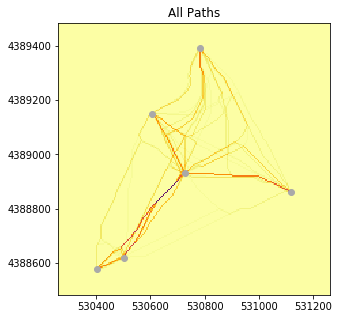

In [21]:
utils.plot_map({'ras':all_paths, 'profile':profile}, loc=df, title='All Paths', cmap= 'inferno_r')

In [71]:
def path_stats(df_paths, all_paths, df, fun={'fun':np.sum, 'name':'sum'}):
    '''
    Extracts path statistics from combined network iterations
    
    Parameters
    ----------
    
    df_paths: pandas dataframe
        dataframe containing paths
    
    all_paths: 2D numpy array
        raster of current path network
    
    df: pandas dataframe
        original dataframe with location information
    
    fun: dictionary
        two element dictionary:
            - 'fun':  function
            - 'name': function name    
    
    Results
    -------
    
    df_paths: pandas dataframe
        all path information plus statistic
    
    '''
    # unpack fun
    f= fun['fun']
    name = fun['name']
    
    # initialize variables
    path_ids = []
    path_stats = []  
    i=0   
    
    for _,pth in df_paths.iterrows():
        
        # progress
        i +=1
        progress(i)
        
        # extract current path values
        path_values = all_paths[pth['track'][0], pth['track'][1]]
        
        # find origin and destination ids
        sel = (df['r'] == pth['origin'][0]) & (df['c'] == pth['origin'][1])
        o = df.loc[sel]['id'].values[0]
        sel = (df['r'] == pth['destination'][0]) & (df['c'] == pth['destination'][1])
        d = df.loc[sel]['id'].values[0] 
        
        # generate statistic
        path_ids += [(o,d)]
        path_stats += [f(path_values)]
    
    # Update with new information
    df_paths['path_ids'] = path_ids
    df_paths[name] = path_stats
    
    return df_paths[['id', 'path_ids', 'origin', 'destination', 'track', name]]

In [72]:
df_pths= path_stats(df_paths, all_paths, df)

.........X.........X.........X

In [73]:
df_pths

,id,path_ids,origin,destination,track,sum
0,1,"(3, 1)","[172, 48]","[124, 171]","[[124, 124, 124, 124, 124, 123, 123, 122, 122,...",882.0
1,2,"(3, 0)","[172, 48]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",854.0
2,3,"(3, 2)","[172, 48]","[180, 28]","[[180, 180, 179, 179, 178, 178, 177, 177, 177,...",60.0
3,4,"(3, 5)","[172, 48]","[66, 68]","[[66, 67, 68, 68, 69, 70, 71, 72, 73, 74, 75, ...",728.0
4,5,"(3, 4)","[172, 48]","[110, 93]","[[110, 109, 108, 107, 106, 105, 104, 103, 102,...",787.0
5,6,"(1, 0)","[124, 171]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",228.0
6,7,"(1, 2)","[124, 171]","[180, 28]","[[180, 179, 178, 177, 176, 175, 174, 173, 172,...",1057.0
7,8,"(1, 5)","[124, 171]","[66, 68]","[[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, ...",491.0
8,9,"(1, 4)","[124, 171]","[110, 93]","[[110, 109, 108, 107, 106, 105, 104, 103, 102,...",360.0
9,10,"(0, 2)","[18, 104]","[180, 28]","[[180, 179, 178, 177, 176, 175, 174, 173, 172,...",1015.0


In [77]:
df_max_paths = df_pths.loc[df_pths.groupby(['path_ids'])['sum'].idxmax()]
df_max_paths

,id,path_ids,origin,destination,track,sum
9,10,"(0, 2)","[18, 104]","[180, 28]","[[180, 179, 178, 177, 176, 175, 174, 173, 172,...",1015.0
29,30,"(0, 4)","[18, 104]","[110, 93]","[[110, 110, 110, 110, 110, 110, 109, 109, 108,...",316.0
10,11,"(0, 5)","[18, 104]","[66, 68]","[[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, ...",205.0
25,26,"(1, 0)","[124, 171]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",272.0
6,7,"(1, 2)","[124, 171]","[180, 28]","[[180, 179, 178, 177, 176, 175, 174, 173, 172,...",1057.0
8,9,"(1, 4)","[124, 171]","[110, 93]","[[110, 109, 108, 107, 106, 105, 104, 103, 102,...",360.0
7,8,"(1, 5)","[124, 171]","[66, 68]","[[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, ...",491.0
27,28,"(2, 0)","[180, 28]","[18, 104]","[[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, ...",621.0
13,14,"(2, 4)","[180, 28]","[110, 93]","[[110, 109, 108, 107, 106, 105, 104, 103, 102,...",811.0
12,13,"(2, 5)","[180, 28]","[66, 68]","[[66, 66, 67, 67, 67, 68, 69, 70, 71, 72, 73, ...",688.0


In [36]:
utils.rc2pt(df_max_paths.iloc[0]['track'], meta)

[(531119.0176069811, 4388860.914627843),
 (531119.0176069811, 4388865.914627843),
 (531114.0176069811, 4388870.914627843),
 (531109.0176069811, 4388875.914627843),
 (531109.0176069811, 4388880.914627843),
 (531104.0176069811, 4388885.914627843),
 (531104.0176069811, 4388890.914627843),
 (531099.0176069811, 4388895.914627843),
 (531094.0176069811, 4388900.914627843),
 (531089.0176069811, 4388905.914627843),
 (531084.0176069811, 4388910.914627843),
 (531084.0176069811, 4388915.914627843),
 (531079.0176069811, 4388920.914627843),
 (531079.0176069811, 4388925.914627843),
 (531074.0176069811, 4388930.914627843),
 (531069.0176069811, 4388935.914627843),
 (531064.0176069811, 4388940.914627843),
 (531059.0176069811, 4388945.914627843),
 (531054.0176069811, 4388950.914627843),
 (531049.0176069811, 4388955.914627843),
 (531044.0176069811, 4388960.914627843),
 (531039.0176069811, 4388965.914627843),
 (531034.0176069811, 4388970.914627843),
 (531034.0176069811, 4388975.914627843),
 (531029.0176069

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# calculate extension
bounds = raster['meta']['bounds']
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]


fig, ax = plt.subplots(ncpls= 1, figsize= (10,10))
im = ax.

##### Plot results

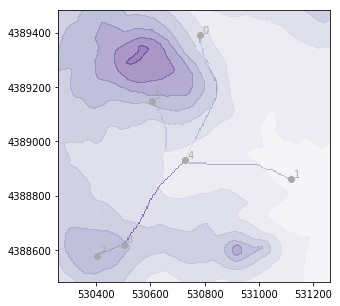

In [22]:
utils.plot_map({'ras':dem, 'meta':meta, 'paths':paths}, loc={'df':df, 'label':'id'}, cmap='magma')

In [28]:
list(netpaths.keys())[-1]

15

In [23]:
Ts = [1, 3, 5, 10, 15]
Ws = [0.5]

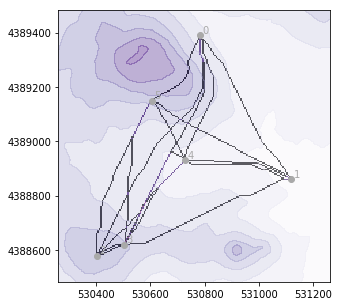

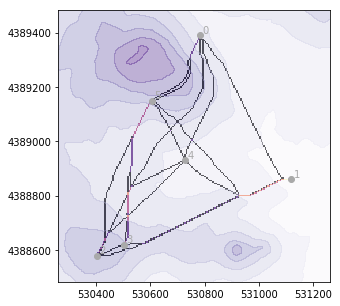

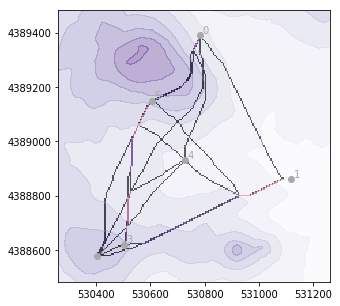

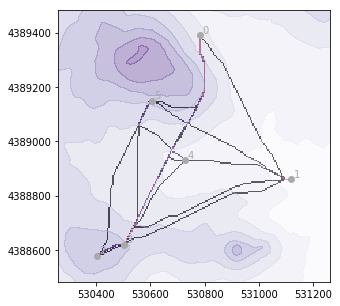

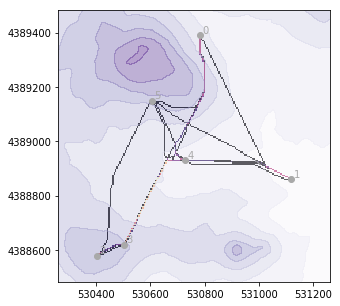

In [24]:
# set weight to 0.5
cost_dict['weight'] = 0.5

for T in Ts:
    # Change the residuality
    netsim_dict['T'] = T
    
    # run simulation
    g, paths, netpaths = ns.simulation(df, df_net, cost_dict, netsim_dict)
    
    # printout results
    utils.plot_map({'ras':dem, 'meta':meta, 'paths':paths}, loc={'df':df, 'label':'id'}, cmap='magma')

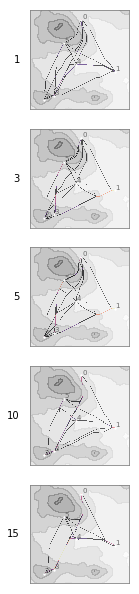

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# calculate extension
bounds = meta['bounds']
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

bla = list(zip(df['id'].values, df['easting'].values, df['northing'].values))
cmap1 = mpl.cm.get_cmap('magma')
cmap2 = mpl.cm.get_cmap('Greys')
nr = len(Ts)

fig, axs = plt.subplots(nr, 1, sharey= 'row',figsize=(7.48,10.54), edgecolor='blue')
for r in range(nr):

    # update residuality
    netsim_dict['T'] = Ts[r]

    # generate network
    g, paths , _ = ns.simulation(df, df_net, cost_dict, netsim_dict)

    # get rid off paths background
    MA = np.ma.array(paths, mask=paths == 0.0)

    # plot results
    axs[r].contourf(dem, 5, cmap= cmap2, extent=extent, origin= 'upper', alpha= 0.4)
    #im1 = axs[r].imshow(hillshade, cmap=cmap2, extent= extent, origin='upper', alpha=0.75)
    im2 = axs[r].imshow(MA, cmap=cmap1, extent= extent, origin='upper')

    # Remove tick marks
    axs[r].xaxis.set_major_locator(plt.NullLocator())
    axs[r].yaxis.set_major_locator(plt.NullLocator())
    
    axs[r].spines['top'].set_color('gray')
    axs[r].spines['bottom'].set_color('gray')
    axs[r].spines['right'].set_color('gray')
    axs[r].spines['left'].set_color('gray')

    # Label points
    axs[r].scatter(df['easting'],df['northing'], color='w', s=2)
    for id, x, y in bla:
        axs[r].annotate(str(id), xy=(x, y), xytext=(1.0, 1.0),
                       textcoords='offset points', fontsize=7, color='dimgray')

    # label axis
    axs[r].text(-0.1,0.5,str(Ts[r]), ha='right', va='center',transform=axs[r].transAxes)

#fig.tight_layout(pad=0, w_pad=0, h_pad=-10) # -26

fig.savefig('test.png', bbox_inches='tight', dpi= 300)
plt.show()